In [4]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

from scipy import stats 
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from colorsetup import colors, palette

### Read the data

In [5]:
gcr_data = pd.read_csv("gcr_processed.csv")

In [6]:
gcr_data.head()

,Age,Sex,Job,Credit amount,Duration,Risk,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Credit_amount/duration
0,4.219508,1,2,7.064759,1.945910,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,3.630568
1,3.135494,0,2,8.691483,3.891820,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,2.233269
2,3.912023,1,1,7.648263,2.564949,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,2.981838
3,3.828641,1,2,8.972464,3.761200,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,2.385532
4,3.988984,1,2,8.491055,3.218876,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,2.637894


<a id="Preprocessing"></a> <br>
# **4. Preprocess**

<h2>4.1 Separating feature and target</h2>

In [7]:
X = gcr_data.drop(['Risk','Credit_amount/duration'], axis=1)
y = gcr_data['Risk']

In [8]:
X.shape

(1000, 23)

In [18]:
from sklearn.linear_model import LogisticRegression


# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 23):
        estimator = LogisticRegression()
        rfe = RFE(estimator=estimator, n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [19]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [20]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    #print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_, rfe.ranking_))

>2 0.686 (0.022)
>3 0.710 (0.041)
>4 0.711 (0.039)
>5 0.695 (0.048)
>6 0.693 (0.066)
>7 0.685 (0.073)
>8 0.664 (0.052)
>9 0.653 (0.052)
>10 0.652 (0.048)
>11 0.656 (0.049)
>12 0.650 (0.044)
>13 0.655 (0.043)
>14 0.658 (0.048)
>15 0.658 (0.047)
>16 0.671 (0.042)
>17 0.673 (0.050)
>18 0.663 (0.047)
>19 0.656 (0.040)
>20 0.659 (0.044)
>21 0.653 (0.035)
>22 0.662 (0.039)


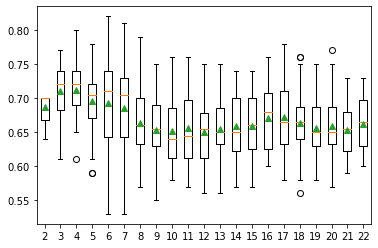

In [21]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [22]:
from sklearn.feature_selection import RFECV

# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.651 (0.041)


In [18]:
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=14)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [25]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [26]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


>lr 0.659 (0.050)
>per 0.679 (0.049)
>cart 0.633 (0.053)
>rf 0.647 (0.046)
>gbm 0.643 (0.041)


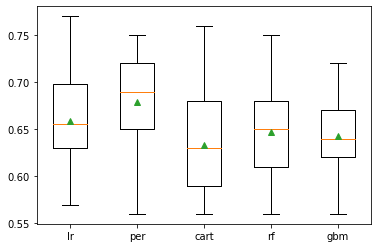

In [27]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()